In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for kpss
import plotly.graph_objects as go
import warnings

warnings.filterwarnings("ignore")

In [4]:
start = "2000-01-01"
end = "2018-12-31"
start_test = "2018-01-01"
end_test = "2024-04-21"

df_vix = yf.download("^VIX", start, end)
df_gspc_raw = yf.download("^GSPC", "1999-12-25", end_test)

df_vix_test = yf.download("^VIX", start_test, end_test)

df_vix.columns = df_vix.columns.str.lower()
df_vix_test.columns = df_vix_test.columns.str.lower()
df_gspc_raw.columns = df_gspc_raw.columns.str.lower()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
df_gspc_raw["adj close_shift_1"] = df_gspc_raw["adj close"].shift(1)
df_gspc_raw["log_return"] = np.log(
    df_gspc_raw["adj close"] / df_gspc_raw["adj close_shift_1"]
)

In [6]:
df_gspc_raw.loc[start:end]

,open,high,low,close,adj close,volume,adj close_shift_1,log_return
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1469.250000,-0.009595
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,-0.039099
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,0.001920
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,0.000955
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,0.026730
...,...,...,...,...,...,...,...,...
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2416.620117,-0.027487
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2351.100098,0.048403
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2467.699951,0.008526


In [7]:
df_gspc_test = df_gspc_raw.loc[start_test:end_test].copy()
df_gspc = df_gspc_raw.loc[start:end].copy()

In [8]:
df_gspc

,open,high,low,close,adj close,volume,adj close_shift_1,log_return
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1469.250000,-0.009595
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,-0.039099
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,0.001920
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,0.000955
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,0.026730
...,...,...,...,...,...,...,...,...
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2416.620117,-0.027487
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2351.100098,0.048403
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2467.699951,0.008526


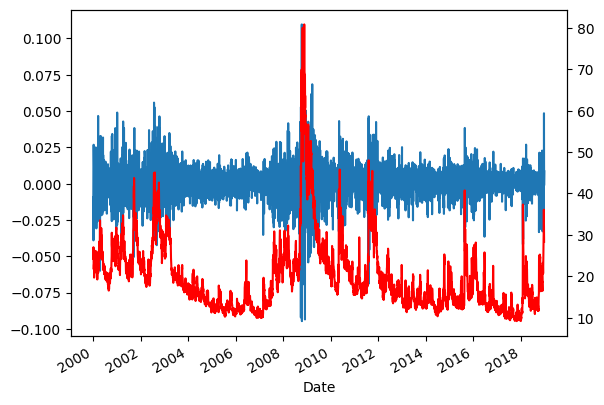

In [9]:
plt.figure()
df_gspc["log_return"].plot()
plt.gca().twinx().plot(df_vix["adj close"], color="red")
plt.show()

In [10]:
# i should use log_return_shift_1 because is lagged return right ui-1 = ln si-1/si-2; start from 0.
df_gspc

,open,high,low,close,adj close,volume,adj close_shift_1,log_return
Date,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1469.250000,-0.009595
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,-0.039099
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,0.001920
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,0.000955
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,0.026730
...,...,...,...,...,...,...,...,...
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2416.620117,-0.027487
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2351.100098,0.048403
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2467.699951,0.008526


In [11]:
# that means we can only start from the same index as the first log_return_shift_1, that should give us
# ok yea correct
df_vix["adj close_shift_1"] = df_vix["adj close"].shift(1)
df_vix

,open,high,low,close,adj close,volume,adj close_shift_1
Date,,,,,,,
2000-01-03,24.360001,26.150000,23.980000,24.209999,24.209999,0,NaN
2000-01-04,24.940001,27.180000,24.799999,27.010000,27.010000,0,24.209999
2000-01-05,27.980000,29.000000,25.850000,26.410000,26.410000,0,27.010000
2000-01-06,26.680000,26.709999,24.700001,25.730000,25.730000,0,26.410000
2000-01-07,25.139999,25.170000,21.719999,21.719999,21.719999,0,25.730000
...,...,...,...,...,...,...,...
2018-12-21,28.240000,31.350000,25.709999,30.110001,30.110001,0,28.379999
2018-12-24,29.290001,36.099998,29.160000,36.070000,36.070000,0,30.110001
2018-12-26,35.500000,36.200001,29.590000,30.410000,30.410000,0,36.070000


In [12]:
df_vix_test

,open,high,low,close,adj close,volume
Date,,,,,,
2018-01-02,10.950000,11.070000,9.520000,9.770000,9.770000,0
2018-01-03,9.560000,9.650000,8.940000,9.150000,9.150000,0
2018-01-04,9.010000,9.310000,8.920000,9.220000,9.220000,0
2018-01-05,9.100000,9.540000,9.000000,9.220000,9.220000,0
2018-01-08,9.610000,9.890000,9.320000,9.520000,9.520000,0
...,...,...,...,...,...,...
2024-04-15,16.940001,19.459999,16.260000,19.230000,19.230000,0
2024-04-16,19.490000,19.559999,17.639999,18.400000,18.400000,0
2024-04-17,18.240000,19.110001,17.540001,18.209999,18.209999,0


In [13]:
df_vix_test = df_vix_test[["close"]]

In [14]:
# EDA CHECK
pd.DataFrame.equals(df_vix["close"], df_vix["adj close"])
df_vix = df_vix[["close"]]
df_vix.head(10)

,close
Date,
2000-01-03,24.209999
2000-01-04,27.010000
2000-01-05,26.410000
2000-01-06,25.730000
2000-01-07,21.719999
2000-01-10,21.709999
2000-01-11,22.500000
2000-01-12,22.840000
2000-01-13,21.709999


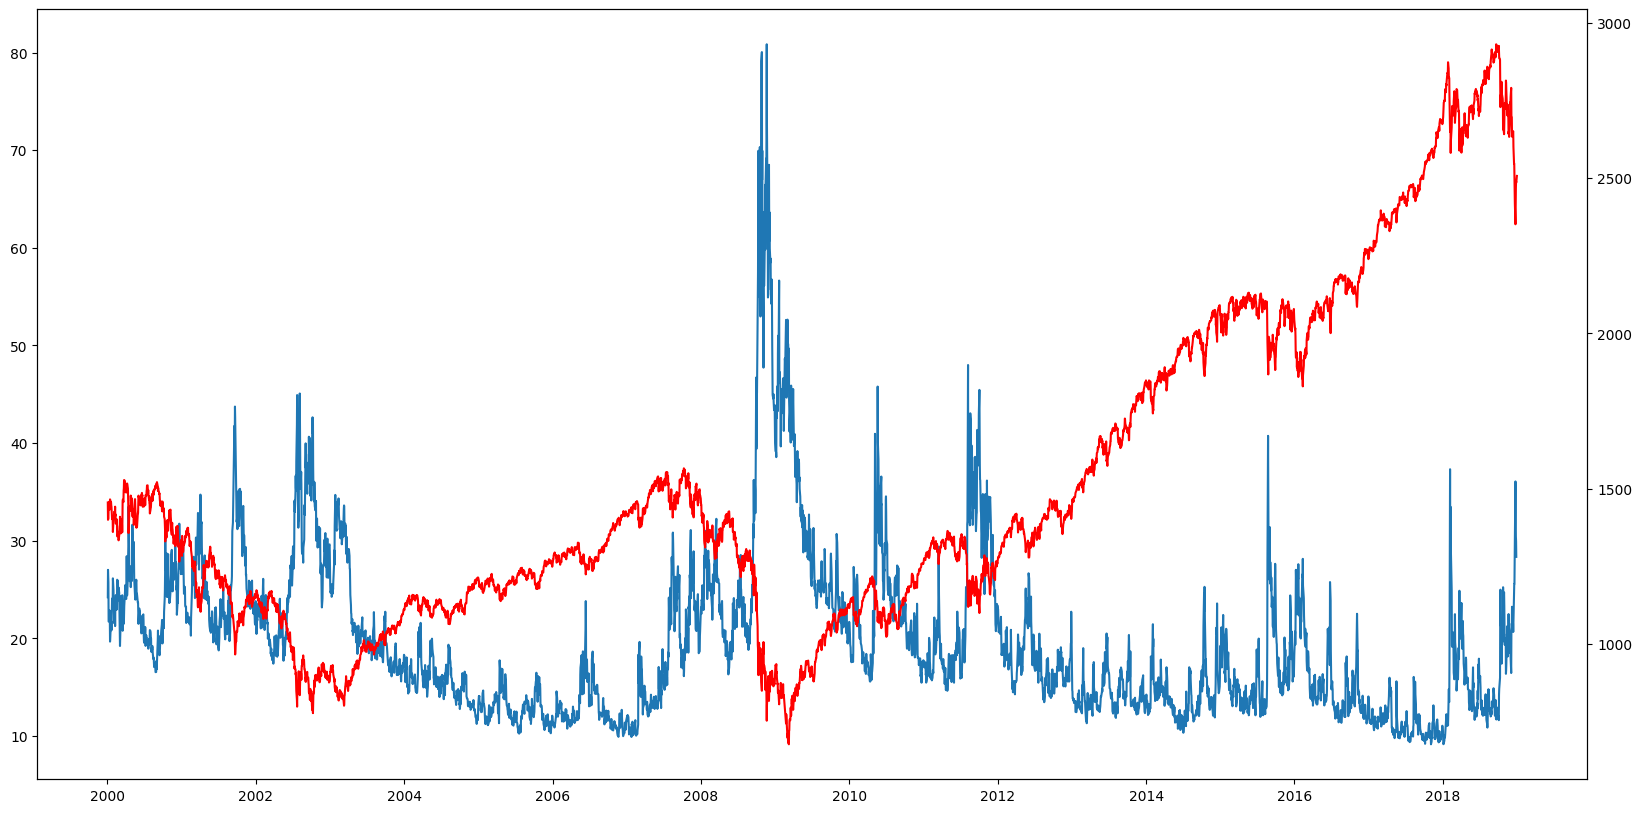

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(df_vix["close"], label="vix")
plt.gca().twinx().plot(df_gspc["close"], color="red", label="sp500")

# 1. CHECK STATIONARY
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [16]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [17]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [18]:
# NULL = STATIONARY
# ALTERNATE = NON STATIONARY
# cant reject NULL at 95% confidence interval; the series is stationary
kpsstest = kpss_test(df_vix)

Results of KPSS Test:
Test Statistic            1.448644
p-value                   0.010000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [19]:
# NULL = non stationary
# ALTERNATE = STATIONARY
# can reject NULL at 95% and 99% confidence interval; The series has no unit root. (series is stationary)
adftest = adf_test(df_vix)

Results of Dickey-Fuller Test:
Test Statistic                   -4.310837
p-value                           0.000425
#Lags Used                       18.000000
Number of Observations Used    4759.000000
Critical Value (1%)              -3.431725
Critical Value (5%)              -2.862148
Critical Value (10%)             -2.567093
dtype: float64


It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

seems to be case 2 without doing anything !


In [20]:
kpss_gspc = kpss_test(df_gspc["log_return"].dropna())

Results of KPSS Test:
Test Statistic            0.270319
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [21]:
adf_gspc = adf_test(df_gspc["log_return"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.672857e+01
p-value                        1.389272e-29
#Lags Used                     1.700000e+01
Number of Observations Used    4.761000e+03
Critical Value (1%)           -3.431724e+00
Critical Value (5%)           -2.862147e+00
Critical Value (10%)          -2.567093e+00
dtype: float64


# ACF TEST

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

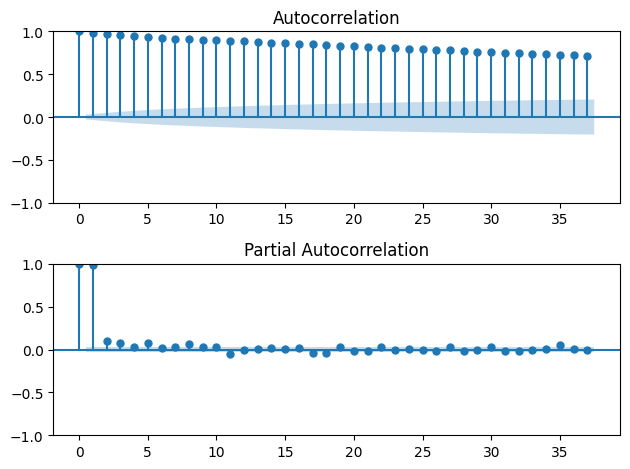

In [23]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_vix["close"], ax=ax[0])
plot_pacf(df_vix["close"], ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

# 1B. AR(1) MODEL FOR VIX

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
AIC: 18334.58091837689 
BIC: 18418.684060294552 
HQIC: 18364.129092169824


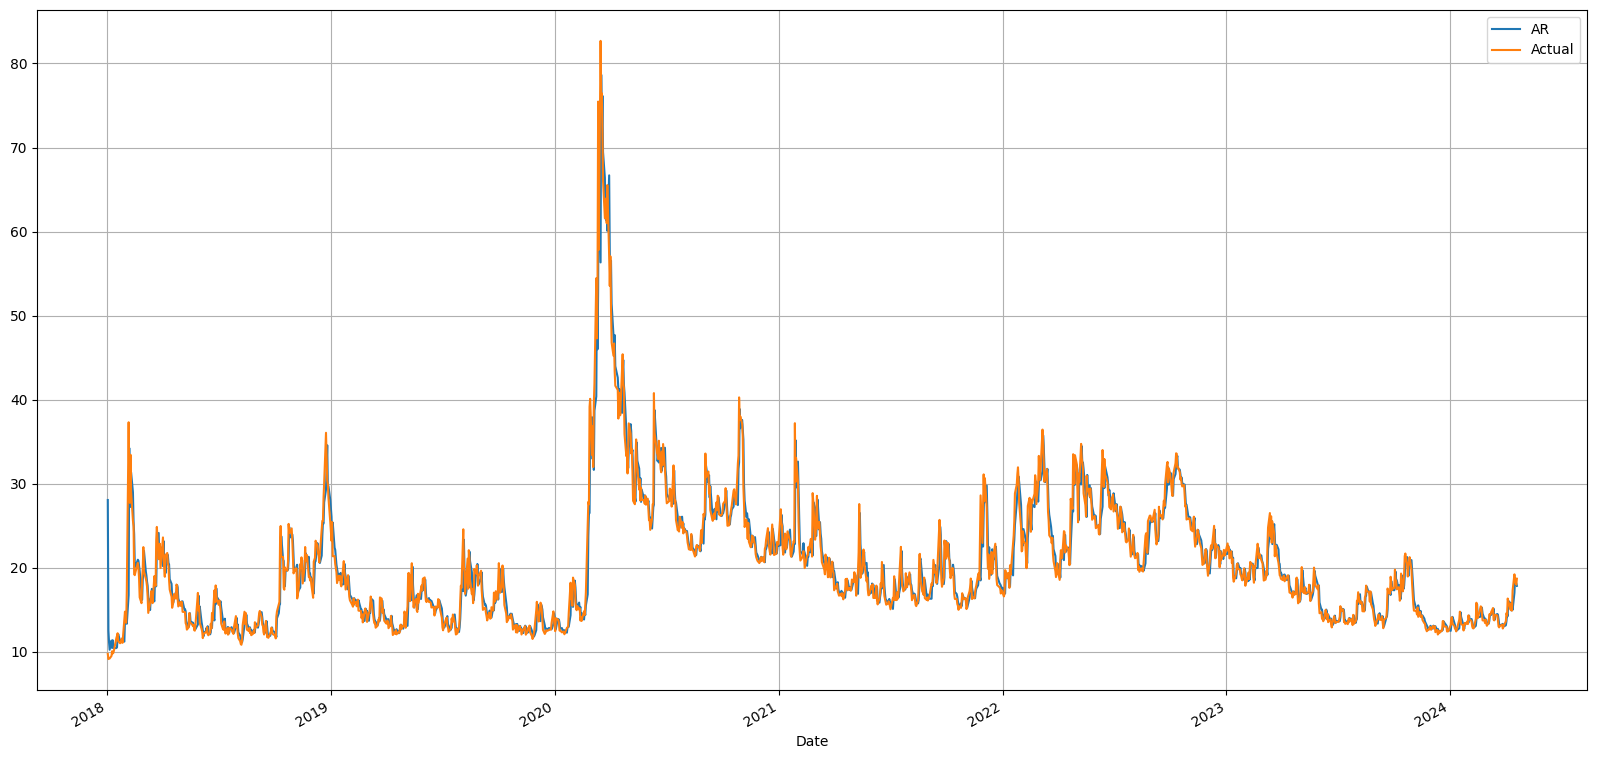

In [24]:
# Visually this is AR1, but we let the ar_select_order decide
from statsmodels.tsa.ar_model import ar_select_order

select = ar_select_order(df_vix["close"], 15, "aic", trend="c", seasonal=False)
print(select.ar_lags)  # show all selected lags

res = select.model.fit()
print("AIC: {0} \nBIC: {1} \nHQIC: {2}".format(res.aic, res.bic, res.hqic))

testing = pd.concat([df_vix["close"], df_vix_test["close"]])
prediction = []

for i in range(len(df_vix["close"]), len(df_vix["close"]) + len(df_vix_test["close"])):
    updated_res = res.apply(testing[:i])
    prediction.append(updated_res.forecast(1).iloc[0])

predictions = pd.DataFrame(
    {
        "AR": prediction,
        "Actual": df_vix_test["close"],
    }
)
_, ax = plt.subplots(figsize=(20, 10))
ax = predictions.plot(ax=ax)
ax.grid()

In [25]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_vix_test.index, y=df_vix_test["close"], mode="lines", name="VIX CLOSE"
    )
)
fig.add_trace(
    go.Scatter(
        x=df_vix_test.index, y=prediction, mode="lines", name="PREDICTION WITH AR(1)"
    )
)
fig.update_layout(title="VIX and AR(1) Model Prediction")
fig.show()

# 2. GARCH ON GSCP LOG RETURN

This is an alternate approach

In [26]:
from arch import arch_model

am = arch_model(df_gspc["log_return"])
res = am.fit(last_obs=end, update_freq=5)
print(res.summary())

ModuleNotFoundError: No module named 'arch'

In [25]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_vix.index, y=df_vix["close"], mode="lines", name="VIX CLOSE"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252),
        mode="lines",
        name="IN SAMPLE GARCH",
    ),
    secondary_y=True,
)
fig.update_layout(title="VIX and GARCH(1,1) In Sample Prediction")
fig.show()

In [30]:
# this thing probably suggests GARCH works best only at most a few days after an observation
forecasts = res.forecast(horizon=len(df_vix_test))
forecast_series = forecasts.variance.dropna().head().T
# forecast_series.set_index(df_vix_test.index, inplace=True)
print(forecast_series)

Date    2018-12-28  2018-12-31
h.0001    0.000468    0.000415
h.0002    0.000462    0.000410
h.0003    0.000455    0.000404
h.0004    0.000449    0.000399
h.0005    0.000443    0.000394
...            ...         ...
h.1581    0.000148    0.000148
h.1582    0.000148    0.000148
h.1583    0.000148    0.000148
h.1584    0.000148    0.000148
h.1585    0.000148    0.000148

[1585 rows x 2 columns]


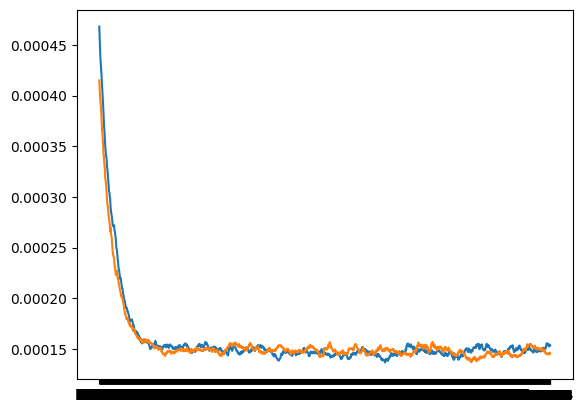

In [27]:
plt.plot(forecast_series)